# Image classification
---

Task: Predict disease type of bean plants using different architectures of neural networks.

Dataset: Beans from TFDS

### 1. Loading dataset

In [ ]:
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import tensorflow_datasets as tfds
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [ ]:
(ds_train, ds_val, ds_test), ds_info = tfds.load("beans", split = ['train', 'validation', 'test'], shuffle_files=True, as_supervised=True, with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/1034 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/beans/0.1.0.incompleteISY72Q/beans-train.tfrecord*...:   0%|          | 0/…

Generating validation examples...:   0%|          | 0/133 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/beans/0.1.0.incompleteISY72Q/beans-validation.tfrecord*...:   0%|         …

Generating test examples...:   0%|          | 0/128 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/beans/0.1.0.incompleteISY72Q/beans-test.tfrecord*...:   0%|          | 0/1…

Dataset beans downloaded and prepared to /root/tensorflow_datasets/beans/0.1.0. Subsequent calls will reuse this data.


### 2. Dataset info
---

Beans is a dataset of images of beans taken in the field using smartphone cameras. It consists of 3 classes: 2 disease classes and the healthy class.  Diseases depicted include Angular Leaf Spot and Bean Rust. Data was annotated by experts from the National Crops Resources Research Institute (NaCRRI) in Uganda and collected by the Makerere AI research lab.

source: https://github.com/AI-Lab-Makerere/ibean/

features: "image", "label"


Dataset split | number of instances
----------------|----------------
train| 1034
validation| 134
test| 128


On all sets, the classes are balanced (i.e. with 354 instances of angular leaf spot, 348 instances of bean rust and 341 images of healthy leaves on trainig set)

In [ ]:
ds_info

tfds.core.DatasetInfo(
    name='beans',
    full_name='beans/0.1.0',
    description="""
    Beans is a dataset of images of beans taken in the field using smartphone
    cameras. It consists of 3 classes: 2 disease classes and the healthy class.
    Diseases depicted include Angular Leaf Spot and Bean Rust. Data was annotated by
    experts from the National Crops Resources Research Institute (NaCRRI) in Uganda
    and collected by the Makerere AI research lab.
    """,
    homepage='https://github.com/AI-Lab-Makerere/ibean/',
    data_dir=PosixGPath('/tmp/tmp0sf4vrvptfds'),
    file_format=tfrecord,
    download_size=171.69 MiB,
    dataset_size=171.63 MiB,
    features=FeaturesDict({
        'image': Image(shape=(500, 500, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=3),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'test': <SplitInfo num_examples=128, num_shards=1>,
        'train': <SplitInfo 

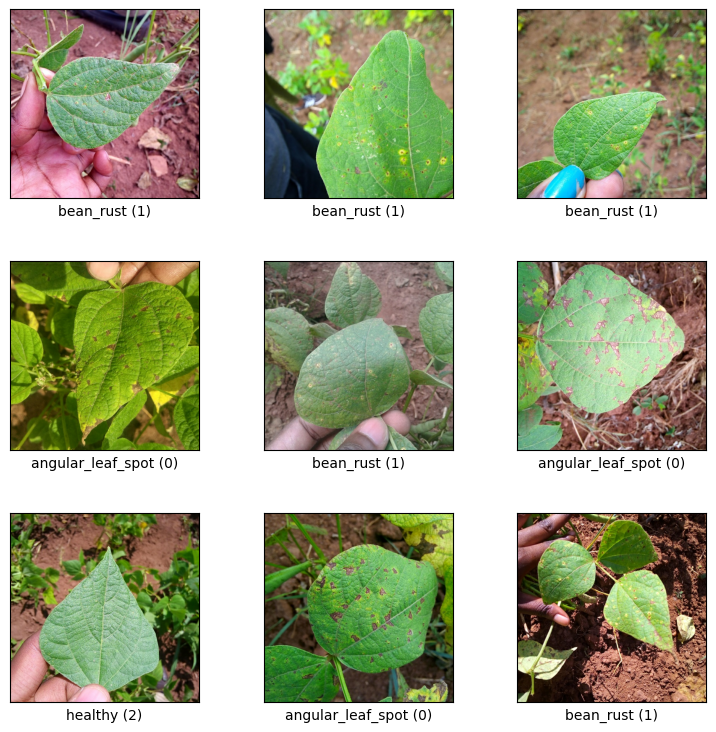

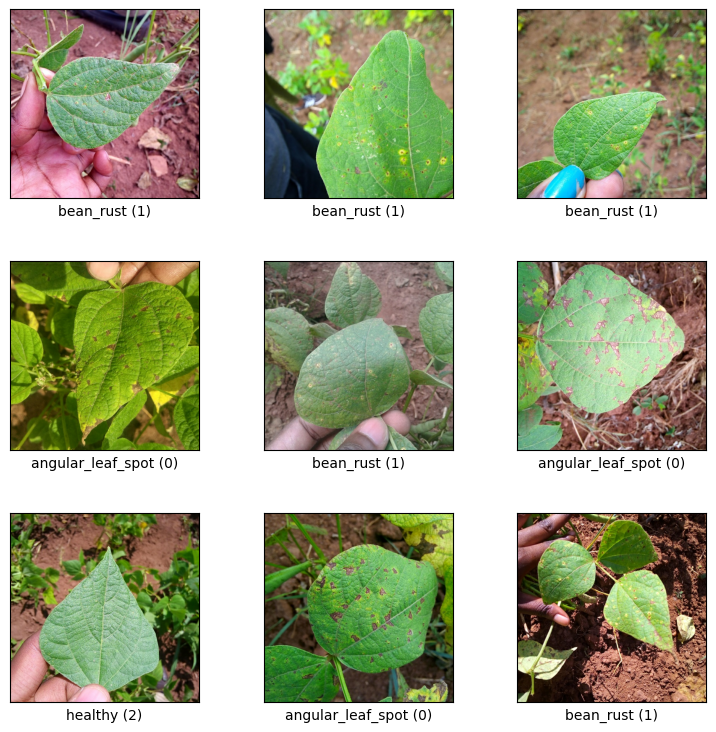

In [ ]:
tfds.show_examples(ds_train, ds_info=ds_info)

In [ ]:
df_train = tfds.as_dataframe(ds_train, ds_info=ds_info)
df_train.head()

,image,label
0,"[[[129, 118, 88], [95, 81, 54], [84, 66, 46], ...",1
1,"[[[64, 88, 14], [65, 89, 15], [66, 88, 15], [6...",0
2,"[[[93, 109, 83], [96, 112, 86], [97, 115, 91],...",1
3,"[[[78, 103, 46], [86, 102, 53], [103, 103, 67]...",2
4,"[[[149, 132, 106], [141, 124, 98], [134, 118, ...",1


label
1    348
0    345
2    341
Name: count, dtype: int64

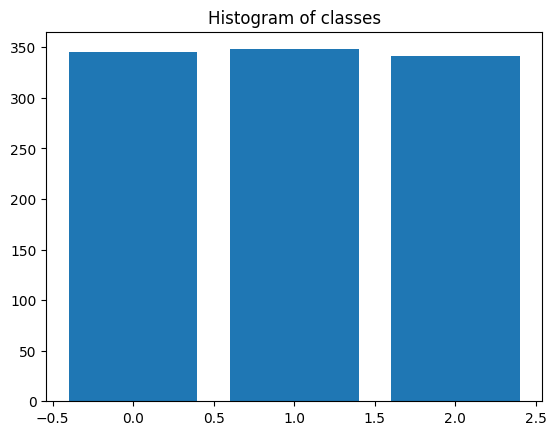

In [ ]:
plt.bar(x=df_train['label'].value_counts().keys(), height=df_train['label'].value_counts())
plt.title(label='Histogram of classes')
df_train['label'].value_counts()

### 3. Preprocessing
---

Includes:
- resizing - making sure all images have the same shape
- rescaling - all pixels have the same representation  
- batching - feed network in batches for faster learning

in addition, trainig data is shuffled to introduce randomness in batch selection.

In [ ]:
IMG_SIZE = 500
batch_size = 32

def resize_rescale(image, label):
    image = tf.cast(image, tf.float32)
    image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])
    image = tf.reshape(image, [-1])
    return image, label

In [ ]:
train_dataset = (
    ds_train
    .shuffle(2000)
    .map(resize_rescale, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(batch_size)
    .prefetch(tf.data.AUTOTUNE)
)

validation_dataset = (
    ds_val
    .map(resize_rescale, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(batch_size)
    .prefetch(tf.data.AUTOTUNE)
)

test_dataset = (
    ds_test
    .map(resize_rescale, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(batch_size)
    .prefetch(tf.data.AUTOTUNE)
)

### 4. Multilayer perceptron
---
- tested different number of dense layers up to 4 layers and numbers of neurons
- adding a third layer caused the network to get confused
- one layer with 256 neurons displayed better results than two layers with 128 -> 256 neurons

---

Architecture:
- input layer
- hidden dense layer with 256 neurons, activation function ReLU (after trial and error yielded best results)
- output layer with 3 neurons (1 for each class) and softmax activation as this function is commonly used for multiclass classification

In this task we are categorizing in three classes using categorical encoding so loss function of choice is sparse categorical crossentropy.

Total of 192 001 027 parameters.

---

Results:
- accuracy at almost 70 %
- 89 images correctly labelled
- 29 incorrectly labelled
- greatest issue is 23 images of bean rust (1) incorrectly classified as angular leaf spot (0), both classes are not healthy
- least errors in healthy class (40 correct, 2 instances labelled as angular leaf spot (0))


In [ ]:
inputs = keras.Input(shape=(IMG_SIZE*IMG_SIZE*3))

x = layers.Dense(256, activation='relu', kernel_initializer=keras.initializers.RandomNormal(stddev=0.1), bias_initializer=keras.initializers.Zeros())(inputs)

outputs = layers.Dense(3, activation='softmax')(x)

mlp = keras.Model(inputs=inputs, outputs=outputs)

mlp.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
mlp.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 750000)]          0         
                                                                 
 dense (Dense)               (None, 256)               192000256 
                                                                 
 dense_1 (Dense)             (None, 3)                 771       
                                                                 
Total params: 192001027 (732.43 MB)
Trainable params: 192001027 (732.43 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
earlystopping_callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, min_delta = 0.02, restore_best_weights=True)

history = mlp.fit(train_dataset, epochs=30, batch_size=32, validation_data=validation_dataset,
                     callbacks=[earlystopping_callback])

Epoch 1/30
33/33 [==============================] - 6s 104ms/step - loss: 89737.7422 - accuracy: 0.3985 - val_loss: 28068.6270 - val_accuracy: 0.3459
Epoch 2/30
33/33 [==============================] - 3s 71ms/step - loss: 10212.4287 - accuracy: 0.5251 - val_loss: 6494.9189 - val_accuracy: 0.5714
Epoch 3/30
33/33 [==============================] - 3s 71ms/step - loss: 3800.3572 - accuracy: 0.5648 - val_loss: 4064.4333 - val_accuracy: 0.4962
Epoch 4/30
33/33 [==============================] - 2s 58ms/step - loss: 2717.2949 - accuracy: 0.6074 - val_loss: 5114.1577 - val_accuracy: 0.5489
Epoch 5/30
33/33 [==============================] - 2s 58ms/step - loss: 2261.7620 - accuracy: 0.6509 - val_loss: 4806.7549 - val_accuracy: 0.5263
Epoch 6/30
33/33 [==============================] - 3s 71ms/step - loss: 4262.1504 - accuracy: 0.5812 - val_loss: 3275.0066 - val_accuracy: 0.5489
Epoch 7/30
33/33 [==============================] - 3s 71ms/step - loss: 2511.2703 - accuracy: 0.6770 - val_loss: 

In [ ]:
def get_conf_matrix(model):
    predictions = model.predict(test_dataset)
    classes = tf.argmax(predictions, axis=-1)
    y_test = tf.concat([y for x, y in test_dataset], axis=0)
    intensity = confusion_matrix(y_test, list(classes.numpy()))
    disp = ConfusionMatrixDisplay(confusion_matrix = intensity, display_labels=[0,1,2])
    disp.plot()

4/4 [==============================] - 0s 15ms/step - loss: 1683.2977 - accuracy: 0.6953
Testing accuracy is  0.6953125
4/4 [==============================] - 0s 13ms/step


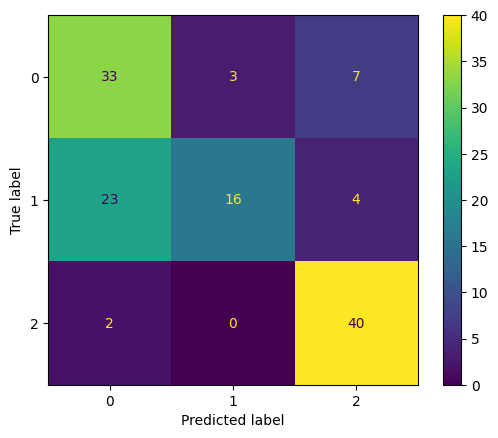

In [ ]:
test_loss, test_acc = mlp.evaluate(test_dataset)
print('Testing accuracy is ', test_acc)
get_conf_matrix(mlp)

### 5. Convolutional neural network
---

Preprocessing:
- different tensor necessary than for perceptron -> different preprocessing
- images are not reshaped
- images are rescaled from 0-255 range to 0-1 (normalization)


- shuffled train dataset
- one size for all images
- split in batches

---


Architecture:
- input layer


- convolution layer with 16 filters
- average pooling with pool_size 5
- convolution layer with 32 filters
- average pooling with pool_size 5
- convolution layers with 64 filters
- average pooling with pool_size 3
- convolution layer with 128 layers


- flatten - gets rid of multidimensionality of tensors
- dropout - helps prevent overfitting
- output layer - dense with 3 neurons

Adding more convolution layers or filters caused to overfit significantly and final accuracy drops.

Max pooling, average pooling and min pooling yielded similar results.

Shrinking the pool size of pooling layers leads to longer training and possible overfitting. Using values 3, 4 and 5 yielded similar results both in accurracy and in distribution of errors in the confusion matrix.

Using ReLU as activation function in convolutional layers proved to be the best solution, hyperbolic tangens could be a good alternative.

Total of 270627 parameters.

---
Results:
- accuracy around 80 %
- easiest class to classify is healthy (2) with 37 correct and 5 incorrect labels (all 5 of class 1)
- most confused class is angular leaf spot (0) with 10 false labels as bean rust (1) and 1 as healthy class (2)
- most instances classified correctly

class | correctly labelled | incorrectly labelled
---|---|---
angular leaf spot|32|11
bean rust|35|8
healthy|37|5







In [ ]:
IMG_SIZE = 500
batch_size = 32

def resize_and_rescale(image, label):
  image = tf.cast(image, tf.float32)
  image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])
  image = (image / 255.0)
  return image, label

train_dataset = (
    ds_train
    .shuffle(2000)
    .map(resize_and_rescale, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(batch_size)
    .prefetch(tf.data.AUTOTUNE)
)

validation_dataset = (
    ds_val
    .map(resize_and_rescale, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(batch_size)
    .prefetch(tf.data.AUTOTUNE)
)

test_dataset = (
    ds_test
    .map(resize_and_rescale, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(batch_size)
    .prefetch(tf.data.AUTOTUNE)
)

In [56]:
inputs = keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))

x = layers.Conv2D(filters=16, kernel_size=5, activation='relu')(inputs)
x = layers.AveragePooling2D(pool_size=5)(x)

x = layers.Conv2D(filters=32, kernel_size=5, activation='relu')(x)
x = layers.AveragePooling2D(pool_size=5)(x)

x = layers.Conv2D(filters=64, kernel_size=5, activation='relu')(x)
x = layers.AveragePooling2D(pool_size=3)(x)

x = layers.Conv2D(filters=128, kernel_size=5, activation='relu')(x)

# s 256 vrstvou dochází k overfittingu a výsledky jdou dolů

x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(3, activation='softmax')(x)

model = keras.Model(inputs=inputs, outputs=outputs)

model.summary()

model.compile(loss='sparse_categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

Model: "model_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_20 (InputLayer)       [(None, 500, 500, 3)]     0         
                                                                 
 conv2d_67 (Conv2D)          (None, 496, 496, 16)      1216      
                                                                 
 average_pooling2d_51 (Aver  (None, 99, 99, 16)        0         
 agePooling2D)                                                   
                                                                 
 conv2d_68 (Conv2D)          (None, 95, 95, 32)        12832     
                                                                 
 average_pooling2d_52 (Aver  (None, 19, 19, 32)        0         
 agePooling2D)                                                   
                                                                 
 conv2d_69 (Conv2D)          (None, 15, 15, 64)        512

In [57]:
callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, min_delta = 0.002, restore_best_weights=True)

history = model.fit(train_dataset, epochs=40, validation_data=validation_dataset, callbacks=[callback])

Epoch 1/40
33/33 [==============================] - 3s 48ms/step - loss: 1.1057 - accuracy: 0.3810 - val_loss: 1.0451 - val_accuracy: 0.4887
Epoch 2/40
33/33 [==============================] - 2s 44ms/step - loss: 1.0185 - accuracy: 0.5039 - val_loss: 0.9237 - val_accuracy: 0.5113
Epoch 3/40
33/33 [==============================] - 2s 44ms/step - loss: 0.9672 - accuracy: 0.5561 - val_loss: 0.9982 - val_accuracy: 0.4586
Epoch 4/40
33/33 [==============================] - 2s 44ms/step - loss: 0.8897 - accuracy: 0.6035 - val_loss: 0.8448 - val_accuracy: 0.6090
Epoch 5/40
33/33 [==============================] - 2s 44ms/step - loss: 0.8355 - accuracy: 0.6480 - val_loss: 0.9706 - val_accuracy: 0.5489
Epoch 6/40
33/33 [==============================] - 2s 44ms/step - loss: 0.7860 - accuracy: 0.6615 - val_loss: 0.7409 - val_accuracy: 0.6767
Epoch 7/40
33/33 [==============================] - 2s 44ms/step - loss: 0.7592 - accuracy: 0.6605 - val_loss: 0.6333 - val_accuracy: 0.6692
Epoch 8/40
33

4/4 [==============================] - 0s 24ms/step - loss: 0.4368 - accuracy: 0.8125
Test dataset accuracy: 0.8125
4/4 [==============================] - 0s 21ms/step


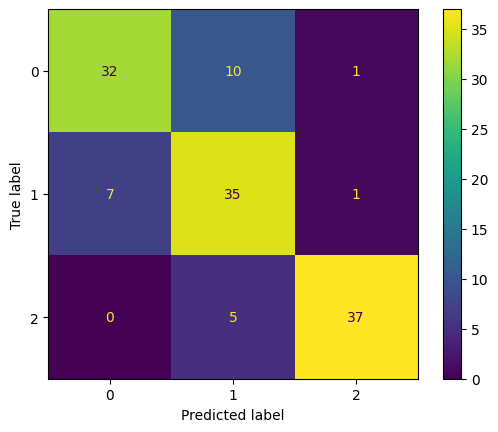

In [59]:
print(f"Test dataset accuracy: {model.evaluate(test_dataset)[1]}")
get_conf_matrix(model)

### 6. Data augmentation
---
- building on the architecture of tested CNN
---

Architecture:
- Gaussian noise layer - introduces a noise which can help prevent overfitting
- Random brightness + Random contrast layers - adding random brightness and random contrast did not benefit the training so we assume most of the images have similar brightness and contrast and these disruptions only harm the trainig process
- Random flip layer - using RandomFlip does not improve the performance of previously evalued model
- Random rotation + Random zoom - emulate the different angles and ways images can be taken and can help prevent overfitting
- The rest of the architecture is CNN from part 5.



Total of 270627 parameters.

---
Results:
- Since the dataset includes only 1034 training instances, too much data augmentation (in this case more than three different layers) only spoils the data we have for training and the model does not perform as well as CNN without data augmentation.


In [100]:
RANDOM_SEED = 42

data_augment = keras.Sequential(
    [
        layers.GaussianNoise(stddev=0.01, seed=RANDOM_SEED),
        #layers.RandomBrightness(factor=0.3, seed=RANDOM_SEED),
        #layers.RandomContrast(factor=0.3, seed=RANDOM_SEED),
        #layers.RandomFlip(seed=RANDOM_SEED),
        layers.RandomRotation(factor=0.3, seed=RANDOM_SEED),
        layers.RandomZoom(height_factor=0.3, seed=RANDOM_SEED),
    ]
)

In [101]:
inputs = keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))

x = data_augment(inputs)

x = layers.Conv2D(filters=16, kernel_size=5, activation='relu')(x)
x = layers.AveragePooling2D(pool_size=5)(x)

x = layers.Conv2D(filters=32, kernel_size=5, activation='relu')(x)
x = layers.AveragePooling2D(pool_size=5)(x)

x = layers.Conv2D(filters=64, kernel_size=5, activation='relu')(x)
x = layers.AveragePooling2D(pool_size=3)(x)

x = layers.Conv2D(filters=128, kernel_size=5, activation='relu')(x)

x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(3, activation='softmax')(x)

model_a = keras.Model(inputs=inputs, outputs=outputs)

model_a.summary()

model_a.compile(loss='sparse_categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

Model: "model_27"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_32 (InputLayer)       [(None, 500, 500, 3)]     0         
                                                                 
 sequential_9 (Sequential)   (None, 500, 500, 3)       0         
                                                                 
 conv2d_115 (Conv2D)         (None, 496, 496, 16)      1216      
                                                                 
 average_pooling2d_87 (Aver  (None, 99, 99, 16)        0         
 agePooling2D)                                                   
                                                                 
 conv2d_116 (Conv2D)         (None, 95, 95, 32)        12832     
                                                                 
 average_pooling2d_88 (Aver  (None, 19, 19, 32)        0         
 agePooling2D)                                            

In [102]:
callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, min_delta = 0.02, restore_best_weights=True)

history = model_a.fit(train_dataset, epochs=40, validation_data=validation_dataset, callbacks=[callback])

Epoch 1/40
33/33 [==============================] - 3s 52ms/step - loss: 1.0912 - accuracy: 0.4091 - val_loss: 0.9898 - val_accuracy: 0.6241
Epoch 2/40
33/33 [==============================] - 2s 48ms/step - loss: 0.9889 - accuracy: 0.5184 - val_loss: 1.0529 - val_accuracy: 0.3910
Epoch 3/40
33/33 [==============================] - 2s 48ms/step - loss: 0.9504 - accuracy: 0.5648 - val_loss: 1.1904 - val_accuracy: 0.4211
Epoch 4/40
33/33 [==============================] - 2s 48ms/step - loss: 0.9196 - accuracy: 0.5967 - val_loss: 0.8477 - val_accuracy: 0.5564
Epoch 5/40
33/33 [==============================] - 2s 48ms/step - loss: 0.8995 - accuracy: 0.5967 - val_loss: 0.8139 - val_accuracy: 0.5940
Epoch 6/40
33/33 [==============================] - 2s 48ms/step - loss: 0.8459 - accuracy: 0.6161 - val_loss: 0.8502 - val_accuracy: 0.5714
Epoch 7/40
33/33 [==============================] - 2s 48ms/step - loss: 0.8318 - accuracy: 0.6383 - val_loss: 1.4600 - val_accuracy: 0.4586
Epoch 8/40
33

4/4 [==============================] - 0s 24ms/step - loss: 0.5869 - accuracy: 0.7812
Test dataset accuracy: 0.78125
4/4 [==============================] - 0s 21ms/step


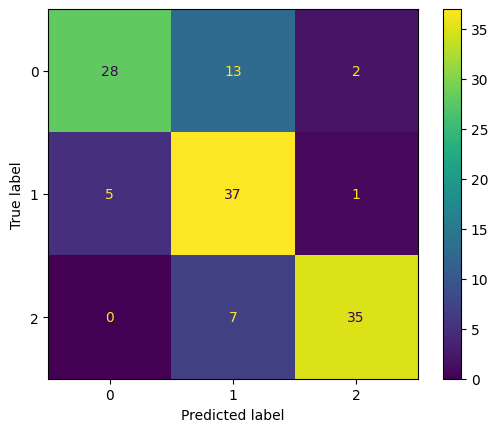

In [103]:
print(f"Test dataset accuracy: {model_a.evaluate(test_dataset)[1]}")
get_conf_matrix(model_a)

As validation and test sets contain very little instances, the loss and accuracy scores are very volatile and therefore harder to evaluate.

These problems could be worked around with different splitting and using upsampling techniques.

Souvislost s jinými semestrálními, případně kvalifikačními, pracemi zpracovávanými v minulosti nebo souběžně
---
 Tato semestrální práce nemá textový ani věcný překryv, ani jinou věcnou souvislost, s jinými semestrálními nebo kvalifikačními pracemi, které jsem zpracovával/a.